### Coursework 2

In this coursework you will be aiming to complete two classification tasks. 
Both the classification tasks relate to text classification tasks. 

One task is to be solved using Support Vector Machines. The other has to be solved using Boosting.

The specific tasks and the marking for the various tasks are provided in the notebook. Each task is expected to be accompanied by a lab-report. Each task can have a concise lab report that is maximum of one page in an A4 size. You will be expected to submit your Jupyter Notebook and all lab reports as a single zip file. You could have additional functions implemented that you require for carrying out each task.


#### Task 1

In this task, you need to obtain sentiment analysis for the provided dataset. The dataset consists of movie reviews with the sentiments being provided. The sentiments are either positive or negative. You need to train an SVM based classifier to obtain train and check on the sample test dataset provided. The method will be evaluated also against an external test set. Please do not hardcode any dimensions or number of samples while writing the code. It should be possible to automate the testing and hardcoding values does not allow for automated testing. 

You are allowed to use scikit-learn to implement the SVM. However, you are expected to write your own kernels.

You are allowed to use the existing library functions such as scikit-learn or numpy for obtaining the SVM. The main idea is to analyse the dataset using different kind of kernels. You are also supposed to write your own custom text kernels. Refer to the documentation provided [here](https://scikit-learn.org/stable/modules/svm.html) at 1.4.6.2 and an example [here](https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html) for writing your own kernels.

Details regarding the marking have been provided in the coursework specification file. Ensure that the code can be run with different test files. 

#### Process the text and obtain a bag of words-based features 

In [1]:
from string import punctuation
import csv
import numpy as np
from collections import Counter
from random import randrange

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams

from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.base import BaseEstimator

import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
# data path
DATA_FOLDER = '/content/drive/MyDrive/ML2-2/data'
TRAIN_DATA_PATH = f"{DATA_FOLDER}/movie_review_train.csv"
TEST_DATA_PATH = f"{DATA_FOLDER}/movie_review_test.csv"

In [3]:
from google.colab import drive

# Mount drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Preprocessing Requirements


In [4]:
def check_spelling(word_list):
  """Check the spelling of words and update them if needed."""
  correct_words = nltk.corpus.words.words()

  for idx, word in enumerate(word_list):
    temp = [(jaccard_distance(set(ngrams(word, 2)), 
                              set(ngrams(correct, 2))), correct) 
            for correct in correct_words if correct[0] == word[0]]
    if len(temp) > 0:
      updated_word = sorted(temp, key = lambda val: val[0])[0][1]
      if word_list[idx] != updated_word:
        word_list[idx] = updated_word
  return word_list

def remove_stop_words(word_list):
  """Removes stop words from a list of words."""
  stopwords = nltk.corpus.stopwords.words('english')
  return [word for word in word_list if word not in stopwords]

def stem_words(word_list):
  """Converts similar words to a single word."""
  snow = SnowballStemmer('english')
  wnl = WordNetLemmatizer()
  for idx, word in enumerate(word_list):
    word_list[idx] = wnl.lemmatize(word) if wnl.lemmatize(word).endswith('e') else snow.stem(word)
  return word_list

In [5]:
nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_data(filepath):
  """
  Retrieves a set of reviews from the given filepath and converts it to lowercase, 
  removing punctuation, checking the spelling, replacing stop words, and
  performs stemming. Returns the updated reviews and its corresponding labels.
  """
  data, labels = [], []
  # Read in data from file and add to list
  with open(filepath, 'r') as file:
    lower_stream = (line.lower() for line in file)
    reader = csv.reader(lower_stream)
    for row in reader:
      data.append(row[0])
      labels.append(row[1])

  # Remove heading
  data, labels = data[1:], labels[1:]
  labels = LabelEncoder().fit(labels).transform(labels) # [positive = 1, negative = 0]
  labels = np.array(labels)
  labels[labels == 0] = -1

  # Convert '/' and HTML tags to spaces
  updated_data = []
  for review in data:
    text = review.replace('<br /><br />', ' ').replace('/', ' ')
    text = ''.join(' ' if char in punctuation else char for char in text)
    text = word_tokenize(text) # split sentence into words

    updated_text = []
    # Remove single character and double character words
    for word in text:
      if not len(word) <= 2:
        updated_text.append(word)
    
    # Check spelling and remove stop words
    updated_text = remove_stop_words(updated_text)
    # updated_text = check_spelling(updated_text) <- takes ages
    updated_text = stem_words(updated_text)
    updated_data.append(updated_text)

  return updated_data, labels

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
def bag_of_words(dataset):
  """Creates bag of words given a dataset."""
  bag_of_words = {}
  # Iterate over each review and word
  for review in dataset:
    for word in review:
      # Add word to dictionary with temp value
      if word not in bag_of_words.keys():
        bag_of_words[word] = 0
  # Convert bag into list and sort in order
  bag_of_words = sorted(list(bag_of_words.keys()))
  return bag_of_words

def get_word_counts(dataset, bag_of_words):
  """Calculates the unique word counts in a given dataset."""
  word_counts = []
  for review in dataset:
    values_dict = {}
    # Create review word count dictionary
    counts_dict = Counter(review)
    # Create dictionary of all words
    for word in bag_of_words:
      if word not in counts_dict.keys():
        values_dict[word] = 0
      else:
        values_dict[word] = counts_dict[word]

    word_counts.append(np.array(list(values_dict.values())))
  return word_counts

In [7]:
def extract_bag_of_words_train_test(train_file, test_file):
  # Read the CSV file and extract Bag of Words Features
  """Creates a list of count values for each review in the training and testing dataset with its respective labels."""
  print('Started preprocessing...', end=' ')
  X_train, y_train = preprocess_data(train_file)
  X_test, y_test = preprocess_data(test_file)
  print('complete.')

  print('Creating bag of words...', end=' ')
  bow = bag_of_words(X_train + X_test)
  print('complete.')

  print('Calculating word counts for train...', end=' ')
  X_train = get_word_counts(X_train, bow)
  print('complete.')
  print('Calculating word counts for test...', end=' ')
  X_test = get_word_counts(X_test, bow)
  print('complete.')

  X_train = np.array(X_train)
  X_test = np.array(X_test)

  return (X_train,y_train,X_test,y_test)

In [8]:
class SVMClassifier(BaseEstimator):
    """Custom SVM classifier that uses the SVC data structure."""
    def __init__(self, kernel):
        self.kernel = kernel
        self.clf = svm.SVC(kernel=kernel)
        self.X_train = None
        if(kernel == 'precomputed'):
          self.check = True
        else:
          self.check = False

    def fit(self, X, y):
        """Fit the data to the classifier."""
        if(self.check):
          gram_train = np.dot(X, X.T)
          self.clf.fit(gram_train, y)
          self.X_train = X
        else:
          self.clf.fit(X, y)

    def predict(self, X_test):
        """Computes the y_preds for the data given."""
        if(self.check):
          X_test = np.dot(X_test, self.X_train.T)
        return self.clf.predict(X_test)

### Test function that will be called to evaluate your code. Separate test dataset will be provided

Do not modify the code below. Please write your code above such that it can be evaluated by the function below. You can modify your code above such that you obtain the best performance through this function. 

In [9]:
(X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test(TRAIN_DATA_PATH, TEST_DATA_PATH)

Started preprocessing... complete.
Creating bag of words... complete.
Calculating word counts for train... complete.
Calculating word counts for test... complete.


In [10]:
def test_func_svm(data, kernels):
    (X_train, Y_train, X_test, Y_test) = data
    accuracies = {}
    # Iterate over kernels
    for kernel in kernels:
      print(f'Classifying using {kernel}:')
      sc = SVMClassifier(kernel=kernel)

      # Handle custom kernel and start training
      print('  Training...', end='')
      if kernel == 'precomputed':
        gram_train = np.dot(X_train, X_train.T)
        X_test = np.dot(X_test, X_train.T)
        sc.fit(gram_train, Y_train)
      else:
        sc.fit(X_train, Y_train)
      print('complete.')

      # Calculate accuracy
      print('  Testing...', end='')
      Y_pred = sc.predict(X_test)
      acc = accuracy_score(Y_test, Y_pred)
      accuracies[kernel] = acc
      print('complete.')
    return accuracies, sc

### Best Score without Crossvalidation on Sigmoid, RBF, and Custom kernel

### Testing Accuracy

In [ ]:
accuracy_beforeCV = test_func_svm((X_train, Y_train, X_test, Y_test), ['rbf', 'sigmoid', 'precomputed'])
print(accuracy_beforeCV)

Classifying using rbf:
  Training...complete.
  Testing...complete.
Classifying using sigmoid:
  Training...complete.
  Testing...complete.
Classifying using precomputed:
  Training...complete.
  Testing...complete.
({'rbf': 0.8426666666666667, 'sigmoid': 0.7433333333333333, 'precomputed': 0.824}, SVMClassifier(kernel='precomputed'))


### Training Accuracy

In [ ]:
train_accuracy_beforeCV = test_func_svm((X_train, Y_train, X_train, Y_train), ['rbf', 'sigmoid', 'precomputed'])
print(train_accuracy_beforeCV)

Classifying using rbf:
  Training...complete.
  Testing...complete.
Classifying using sigmoid:
  Training...complete.
  Testing...complete.
Classifying using precomputed:
  Training...complete.
  Testing...complete.
({'rbf': 0.9698, 'sigmoid': 0.7854, 'precomputed': 1.0}, SVMClassifier(kernel='precomputed'))


### Getting the Best Hyperparameter for Sigmoid and RBF for Crossvalidation

In [ ]:
c_value = [0.5, 1, 1.5]

coef = [0, 0.5, 1]
accs_sig = {}
for c in c_value:
  for f in coef:
    sc = svm.SVC(kernel='sigmoid', C = c, coef0 = f)
    sc.fit(X_train, Y_train)
    Y_pred = sc.predict(X_test)
    acc = accuracy_score(Y_test, Y_pred)
    accs_sig[(c, f)] = acc

accs_rbf = {}
for c in c_value:
  for f in coef:
    sc = svm.SVC(kernel='rbf', C = c, coef0 = f)
    sc.fit(X_train, Y_train)
    Y_pred = sc.predict(X_test)
    acc = accuracy_score(Y_test, Y_pred)
    accs_rbf[(c, f)] = acc

print('Sigmoid:',accs_sig)
print('RBF:', accs_rbf)

Sigmoid: {(0.5, 0): 0.7746666666666666, (0.5, 0.5): 0.7633333333333333, (0.5, 1): 0.7933333333333333, (1, 0): 0.7433333333333333, (1, 0.5): 0.7353333333333333, (1, 1): 0.7673333333333333, (1.5, 0): 0.726, (1.5, 0.5): 0.7166666666666667, (1.5, 1): 0.7453333333333333}
RBF: {(0.5, 0): 0.8233333333333334, (0.5, 0.5): 0.8233333333333334, (0.5, 1): 0.8233333333333334, (1, 0): 0.8426666666666667, (1, 0.5): 0.8426666666666667, (1, 1): 0.8426666666666667, (1.5, 0): 0.842, (1.5, 0.5): 0.842, (1.5, 1): 0.842}


### Crossvalidation for Sigmoid, RBF, Custom kernel

In [11]:
def k_fold_cv_sklearn(classifier, x, y, num_folds=5, **kwargs):
  """Returns the scores of k-fold cross validation."""
  return cross_validate(classifier, x, y, cv=num_folds, **kwargs)

kernels = ['rbf', 'sigmoid','precomputed']
cv_scores = {}
for kernel in kernels:
  if(kernel == 'rbf'):
    cv_results = k_fold_cv_sklearn(svm.SVC(kernel=kernel, C = 1, coef0 = 0), X_train, Y_train, scoring = "accuracy", return_estimator = True)
  elif(kernel == 'sigmoid'):
    cv_results = k_fold_cv_sklearn(svm.SVC(kernel=kernel, C = 0.5, coef0 = 1), X_train, Y_train, scoring = "accuracy", return_estimator = True)
  else:
    sc = SVMClassifier(kernel='precomputed')
    cv_results = k_fold_cv_sklearn(sc, X_train, Y_train, scoring = "accuracy", return_estimator = True)
  cv_scores[kernel] = cv_results

for key, val in cv_scores.items():
  print(f"{key}: {val['test_score']}")

rbf: [0.834 0.847 0.817 0.839 0.859]
sigmoid: [0.808 0.83  0.781 0.816 0.809]
precomputed: [0.824 0.812 0.822 0.821 0.847]


### Best Score for Sigmoid, RBF, Custom kernel After Crossvalidation

In [12]:
best_rbf = cv_scores['rbf']['estimator'][-1]
y_preds_test_rbf = best_rbf.predict(X_test) 
acc = accuracy_score(Y_test, y_preds_test_rbf)
print("RBF test: ", acc)
print("RBF y_preds: ", y_preds_test_rbf)

y_preds_train_rbf = best_rbf.predict(X_train) 
acc = accuracy_score(Y_train, y_preds_train_rbf)
print("RBF train: ", acc)

RBF test:  0.8393333333333334
RBF y_preds:  [-1 -1 -1 ... -1  1 -1]
RBF train:  0.9508


In [13]:
best_sig = cv_scores['sigmoid']['estimator'][1]
y_preds_test_sig= best_sig.predict(X_test) 
acc = accuracy_score(Y_test, y_preds_test_sig)
print("Sigmoid test: ", acc)
print("Sigmoid y_preds: ", y_preds_test_sig)

y_preds_train_sig = best_sig.predict(X_train)
acc = accuracy_score(Y_train, y_preds_train_sig)
print("Sigmoid train: ", acc)

Sigmoid test:  0.8213333333333334
Sigmoid y_preds:  [ 1 -1 -1 ... -1  1 -1]
Sigmoid train:  0.8386


In [14]:
best_pre = cv_scores['precomputed']['estimator'][-1]
y_preds_test_pre= best_pre.predict(X_test) 
acc = accuracy_score(Y_test, y_preds_test_pre)
print("pre test: ", acc)
print("pre y_preds: ", y_preds_test_pre)

y_preds_train_pre = best_pre.predict(X_train)
acc = accuracy_score(Y_train, y_preds_train_pre)
print("pre train: ", acc)

pre test:  0.8293333333333334
pre y_preds:  [ 1  1  1 ... -1  1 -1]
pre train:  0.9694


### Confusion Matrix for Sigmoid, RBF, Custom kernel

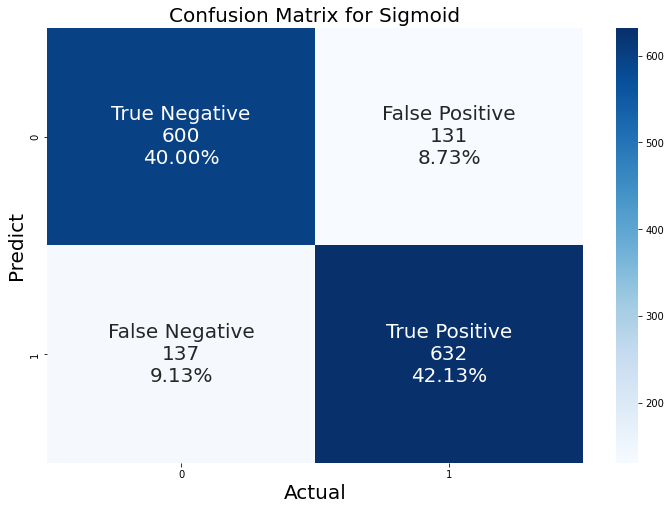

In [ ]:
sig_c_matrix = confusion_matrix(Y_test, y_preds_test_sig)

plt.figure(figsize=(12,8))

label_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
counts = ['{0:0.0f}'.format(value) for value in sig_c_matrix.flatten()]
percentages = ['{0:.2%}'.format(value) for value in sig_c_matrix.flatten()/np.sum(sig_c_matrix)]
labels = [f'{names}\n{counts}\n{percentages}' for names, counts, percentages in zip(label_names, counts, percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sn.heatmap(sig_c_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 20})
ax.set_ylabel('Predict', fontsize=20)
ax.set_xlabel('Actual',fontsize=20)
ax.set_title("Confusion Matrix for Sigmoid", fontsize=20)
plt.show()

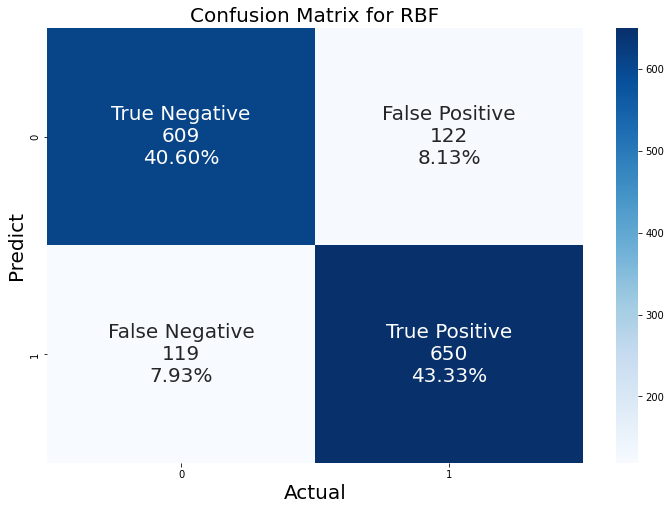

In [ ]:
rbf_c_matrix = confusion_matrix(Y_test, y_preds_test_rbf)

plt.figure(figsize=(12,8))

label_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
counts = ['{0:0.0f}'.format(value) for value in rbf_c_matrix.flatten()]
percentages = ['{0:.2%}'.format(value) for value in rbf_c_matrix.flatten()/np.sum(rbf_c_matrix)]
labels = [f'{names}\n{counts}\n{percentages}' for names, counts, percentages in zip(label_names, counts, percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sn.heatmap(rbf_c_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 20})
ax.set_ylabel('Predict', fontsize=20)
ax.set_xlabel('Actual',fontsize=20)
ax.set_title("Confusion Matrix for RBF", fontsize=20)
plt.show()

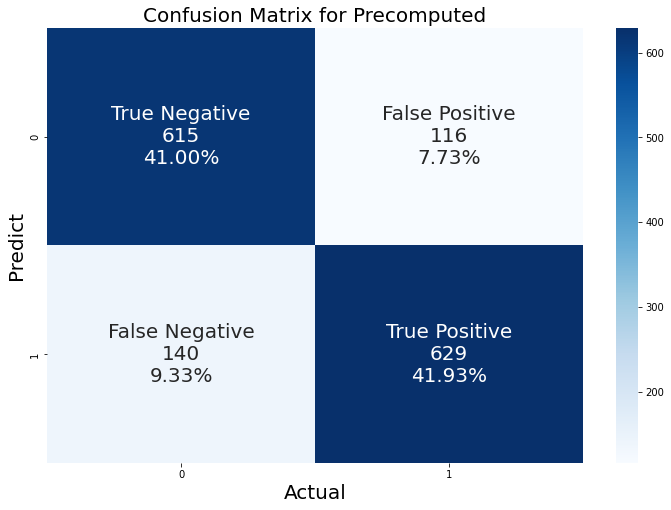

In [ ]:
custom_c_matrix = confusion_matrix(Y_test, y_preds_test_pre)

plt.figure(figsize=(12,8))

label_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
counts = ['{0:0.0f}'.format(value) for value in custom_c_matrix.flatten()]
percentages = ['{0:.2%}'.format(value) for value in custom_c_matrix.flatten()/np.sum(custom_c_matrix)]
labels = [f'{names}\n{counts}\n{percentages}' for names, counts, percentages in zip(label_names, counts, percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sn.heatmap(custom_c_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 20})
ax.set_ylabel('Predict', fontsize=20)
ax.set_xlabel('Actual',fontsize=20)
ax.set_title("Confusion Matrix for Precomputed", fontsize=20)
plt.show()

### Calculate average length of Misclassified reviews

In [15]:
def length_misclassified(X, Y, y_pred):
  misclassified = X[y_pred != Y]
  sum = 0
  for x in misclassified:
    for i in x:
      sum += i
  sum /= misclassified.shape[0] #avg length of misclassified reviews
  return sum

def length_overall(X):
  sum = 0
  for x in X:
    for i in x:
      sum += i
  sum /= X.shape[0] #avg length of test reviews
  return sum

print('avg length of review:', length_overall(X_test))
print('avg length of misclassified review of RBF:', length_misclassified(X_test, Y_test, y_preds_test_rbf))
print('avg length of misclassified review of Sigmoid:', length_misclassified(X_test, Y_test, y_preds_test_sig))
print('avg length of misclassified review of precomputed:', length_misclassified(X_test, Y_test, y_preds_test_pre))

avg length of review: 120.296
avg length of misclassified review of RBF: 125.2116182572614
avg length of misclassified review of Sigmoid: 113.04477611940298
avg length of misclassified review of precomputed: 112.7421875


### Task 2

In this task you need to implement a boosting based classifier that can be used to classify the images. 

Details regarding the marking for the coursework are provided in the coursework specification file. Please ensure that your code will work with a different test file than the one provided with the coursework.

Note that the boosting classifier you implement can include decision trees from scikit-learn or your own decision trees. Use the same sentiment analysis dataset for evaluation.

In [ ]:
class BoostingClassifier(BaseEstimator):
    # You need to implement this classifier. 
    def __init__(self, num_classifiers, max_depth):
        # Implement initialisation
        self.weak_classifiers = []
        self.alphas = []
        self.weights = []
        self.all_y_preds = []
        self.num_classifiers = num_classifiers
        self.max_depth = max_depth

    def fit(self, X, y):
        # Implement training of the boosting classifier
        weights = np.ones(len(X)) / len(X) # Initialise array of uniform weights -> 1/N, for each sample

        print(f'Using {self.num_classifiers} classifiers: ', end='')
        for i in range(0, self.num_classifiers):
          print(f'{i+1} ', end='')
          model_tree = DecisionTreeClassifier(max_depth = self.max_depth) # Weak classifier
          model_tree.fit(X, y, sample_weight = weights) # Creates tree
          self.weak_classifiers.append(model_tree) # Have list of all weak classifiers

          # Make initial predictions
          y_preds = model_tree.predict(X)

          # Calc estimator error
          miss_classified = np.not_equal(y, y_preds)
          err = np.sum(miss_classified * weights)

          # Calc alpha (estimator weight)
          alpha = 0.5 * np.log((1 - err) / err)
          self.alphas.append(alpha)

          # Calculate the new weights
          weights *= np.exp(-1 * alpha * y * y_preds)
          self.weights.append(weights)

        print('...complete.')

    def predict(self, X):
      # implement prediction of the boosting classifier
      y_pred = 0
      for i in range(self.num_classifiers):
        y_pred += self.weak_classifiers[i].predict(X) * self.alphas[i]

      output_pred = np.sign(y_pred)

      return output_pred

### Boosting Classifier without Crossvalidation

In [ ]:
def test_func_boosting(data, num_classifiers=10, **kwargs):
    (X_train, Y_train, X_test, Y_test) = data
    bc = BoostingClassifier(num_classifiers, 5)
    bc.fit(X_train, Y_train)
    y_preds = bc.predict(X_test)
    acc = accuracy_score(Y_test, y_preds)
    first_clf_preds = bc.weak_classifiers[0].predict(X_test)
    print('\nAccuracies:')
    print(f'  First: {accuracy_score(Y_test, first_clf_preds):.3f}')
    print(f'  Final: {acc:.3f}')
    return acc

### Testing Accuracy without Crossvalidation

In [ ]:
acc_bc_test = test_func_boosting((X_train, Y_train, X_test, Y_test))

Using 10 classifiers: 1 2 3 4 5 6 7 8 9 10 ...complete.

Accuracies:
  First: 0.728
  Final: 0.735


### Training Accuracy without Crossvalidation

In [ ]:
acc_bc_train = test_func_boosting((X_train, Y_train, X_train, Y_train))

Using 10 classifiers: 1 2 3 4 5 6 7 8 9 10 ...complete.

Accuracies:
  First: 0.728
  Final: 0.797


### Hyperparameter to use in Boosting

In [ ]:
max_depths = [1, 2, 3, 4, 5, 6]
types = ['gini', 'entropy']
splitter_type = ['best', 'random']
metrics = []

total_params = len(max_depths) * len(types) * len(splitter_type)
counter = 1
print(f'Total iterations {total_params}:')
for md in max_depths:
  for c in types:
    for st in splitter_type:
      print(f'{counter} ', end='')
      decision_tree = DecisionTreeClassifier(max_depth=md, criterion=c, splitter=st)
      decision_tree.fit(X_train, Y_train)
      Y_pred = decision_tree.predict(X_test)
      acc = accuracy_score(Y_test, Y_pred)
      metrics.append({'max_depths': md, 'criterion': c, 'split_type': st, 'accuracy': acc})
      counter += 1

Total iterations 24:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [ ]:
for item in metrics:
  print(item)

best_params = {'max_depths': 5, 'criterion': 'gini', 'split_type': 'best', 'accuracy': 0.728}

{'max_depths': 1, 'criterion': 'gini', 'split_type': 'best', 'accuracy': 0.6426666666666667}
{'max_depths': 1, 'criterion': 'gini', 'split_type': 'random', 'accuracy': 0.5513333333333333}
{'max_depths': 1, 'criterion': 'entropy', 'split_type': 'best', 'accuracy': 0.6426666666666667}
{'max_depths': 1, 'criterion': 'entropy', 'split_type': 'random', 'accuracy': 0.5746666666666667}
{'max_depths': 2, 'criterion': 'gini', 'split_type': 'best', 'accuracy': 0.678}
{'max_depths': 2, 'criterion': 'gini', 'split_type': 'random', 'accuracy': 0.6646666666666666}
{'max_depths': 2, 'criterion': 'entropy', 'split_type': 'best', 'accuracy': 0.6646666666666666}
{'max_depths': 2, 'criterion': 'entropy', 'split_type': 'random', 'accuracy': 0.5913333333333334}
{'max_depths': 3, 'criterion': 'gini', 'split_type': 'best', 'accuracy': 0.698}
{'max_depths': 3, 'criterion': 'gini', 'split_type': 'random', 'accuracy': 0.6066666666666667}
{'max_depths': 3, 'criterion': 'entropy', 'split_type': 'best', 'accuracy'

### Cross Validation for Boosting Classifier

In [ ]:
def k_fold_cv_sklearn(classifier, x, y, num_folds=5, **kwargs):
  """Returns the scores of k-fold cross validation."""
  return cross_validate(classifier, x, y, cv=num_folds, **kwargs)
  
num_classifiers = [8, 12, 15]

cv_bcs = []
for nc in num_classifiers:
  bc = BoostingClassifier(num_classifiers=nc, max_depth=5)
  cv_bc = k_fold_cv_sklearn(bc, X_train, Y_train, num_folds=5, scoring = "accuracy", return_estimator = True)
  cv_bcs.append(cv_bc)

Using 8 classifiers: 1 2 3 4 5 6 7 8 ...complete.
Using 8 classifiers: 1 2 3 4 5 6 7 8 ...complete.
Using 8 classifiers: 1 2 3 4 5 6 7 8 ...complete.
Using 8 classifiers: 1 2 3 4 5 6 7 8 ...complete.
Using 8 classifiers: 1 2 3 4 5 6 7 8 ...complete.
Using 12 classifiers: 1 2 3 4 5 6 7 8 9 10 11 12 ...complete.
Using 12 classifiers: 1 2 3 4 5 6 7 8 9 10 11 12 ...complete.
Using 12 classifiers: 1 2 3 4 5 6 7 8 9 10 11 12 ...complete.
Using 12 classifiers: 1 2 3 4 5 6 7 8 9 10 11 12 ...complete.
Using 12 classifiers: 1 2 3 4 5 6 7 8 9 10 11 12 ...complete.
Using 15 classifiers: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...complete.
Using 15 classifiers: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...complete.
Using 15 classifiers: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...complete.
Using 15 classifiers: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...complete.
Using 15 classifiers: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...complete.


In [ ]:
for item in cv_bcs:
  print(item['test_score'])

[0.724 0.756 0.708 0.714 0.752]
[0.735 0.709 0.749 0.73  0.757]
[0.773 0.775 0.738 0.737 0.756]


### Best Boosting Classifier score

In [ ]:
best_bc = cv_bcs[-1]['estimator'][1]
y_preds_test_bc = best_bc.predict(X_test)
acc_test = accuracy_score(Y_test, y_preds_test_bc)
print('bc test:',acc_test)


y_preds_train_bc = best_bc.predict(X_train)
acc_train = accuracy_score(Y_train, y_preds_train_bc)
print('bc train:',acc_train)

bc test: 0.7493333333333333
bc train: 0.8552


### Confusion Matrix for Boosting Classifier

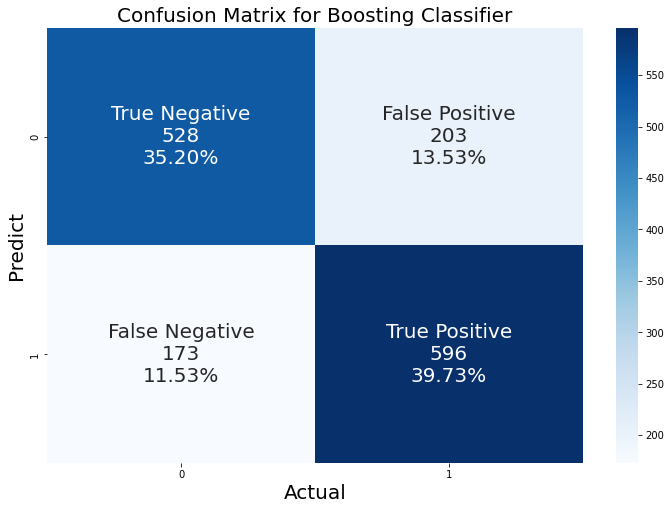

In [ ]:
bc_c_matrix = confusion_matrix(Y_test, y_preds_test_bc)

plt.figure(figsize=(12,8))

label_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
counts = ['{0:0.0f}'.format(value) for value in bc_c_matrix.flatten()]
percentages = ['{0:.2%}'.format(value) for value in bc_c_matrix.flatten()/np.sum(bc_c_matrix)]
labels = [f'{names}\n{counts}\n{percentages}' for names, counts, percentages in zip(label_names, counts, percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sn.heatmap(bc_c_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 20})
ax.set_ylabel('Predict', fontsize=20)
ax.set_xlabel('Actual',fontsize=20)
ax.set_title("Confusion Matrix for Boosting Classifier", fontsize=20)
plt.show()

### Average Length of Misclassified reviews

In [ ]:
print('avg length of misclassified review of BC classifier:', length_misclassified(X_test, Y_test, y_preds_test_bc))

avg length of misclassified review of BC classifier: 121.64893617021276
